In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import textwrap
from nltk.corpus import stopwords
nltk.download("stopwords")

# Packages for evalution
## ROUGE score
from rouge import Rouge
## BLEU score
from nltk.translate.bleu_score import sentence_bleu
## BERT score
import bert_score
## METEOR score
nltk.download('wordnet')
from nltk.translate.meteor_score import meteor_score

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zionshane/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/zionshane/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Step 1: Load datasets

In [2]:
# Read dataset.
def load_dataset(dataset_path: str) -> pd.DataFrame:
    df = pd.read_csv(dataset_path)
    df.drop(columns=['id'], inplace=True) # Drop id column
    df.dropna(inplace=True) # Drop null values (if any)
    return df

In [3]:
# Load train data.
df_train = load_dataset(r'./data/cnn_dailymail/train.csv')
print("Number of records in training set:", len(df_train))
df_train.head()

Number of records in training set: 287113


,article,highlights
0,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


In [4]:
df_val = load_dataset(r'./data/cnn_dailymail/validation.csv')
print("Number of records in validation set:", len(df_val))
df_val.head()

Number of records in validation set: 13368


,article,highlights
0,"Sally Forrest, an actress-dancer who graced th...","Sally Forrest, an actress-dancer who graced th..."
1,A middle-school teacher in China has inked hun...,Works include pictures of Presidential Palace ...
2,A man convicted of killing the father and sist...,"Iftekhar Murtaza, 29, was convicted a year ago..."
3,Avid rugby fan Prince Harry could barely watch...,Prince Harry in attendance for England's crunc...
4,A Triple M Radio producer has been inundated w...,Nick Slater's colleagues uploaded a picture to...


In [5]:
df_test = load_dataset(r'./data/cnn_dailymail/test.csv')
print("Number of records in test set:", len(df_test))
df_test.head()

Number of records in test set: 11490


,article,highlights
0,Ever noticed how plane seats appear to be gett...,Experts question if packed out planes are put...
1,A drunk teenage boy had to be rescued by secur...,Drunk teenage boy climbed into lion enclosure ...
2,Dougie Freedman is on the verge of agreeing a ...,Nottingham Forest are close to extending Dougi...
3,Liverpool target Neto is also wanted by PSG an...,Fiorentina goalkeeper Neto has been linked wit...
4,Bruce Jenner will break his silence in a two-h...,"Tell-all interview with the reality TV star, 6..."


In [6]:
# Print an example article.
example_text = df_train['article'][0]
example_text

"By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A . State Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained 

In [7]:
# Print an example article (the article is wrapped for better readability).
example_text = df_train['article'][0]
print(textwrap.fill(text=example_text, replace_whitespace=False,
                    fix_sentence_endings=True))

By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | .
UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo
Catholic Diocese in North Dakota has exposed potentially hundreds of
church members in Fargo, Grand Forks and Jamestown to the hepatitis A
virus in late September and early October.  The state Health
Department has issued an advisory of exposure for anyone who attended
five churches and took communion.  Bishop John Folda (pictured) of the
Fargo Catholic Diocese in North Dakota has exposed potentially
hundreds of church members in Fargo, Grand Forks and Jamestown to the
hepatitis A . State Immunization Program Manager Molly Howell says the
risk is low, but officials feel it's important to alert people to the
possible exposure.  The diocese announced on Monday that Bishop John
Folda is taking time off after being diagnosed with hepatitis A. The
diocese says he contracted the infection through contaminated food
while attending a conference for newly ordaine

In [8]:
# Print an example given summmary.
example_summary = df_train['highlights'][0]
example_summary

'Bishop John Folda, of North Dakota, is taking time off after being diagnosed .\nHe contracted the infection through contaminated food in Italy .\nChurch members in Fargo, Grand Forks and Jamestown could have been exposed .'

Some problems needs to be fixed in these original given summaries:
- 1. These escape characters (such as `'\n'`) need to be removed;
- 2. The position of periods are not correct. Should be `'some texts. Another'` rather than `'some texts .Another'`.

As we have seen in the examples above, some sentences appear at the beginning or end of an article that do not pertain to its main content. These sentences typically provide brief details such as the name of the publication, the author, or the date of publication. Hence, it is safe to remove such redundant information from the main body of the article. These sentences are usually shorter than those in the main body, which makes it easier to filter them out when building a summarizer.

## Step 2: Data pre-processing

In [9]:
# Remove redundant newline character ('\n').
df_train['highlights'] = df_train['highlights'].str.replace('\n', ' ', regex=True)
# Remove the extra whitespace before the periods.
df_train['highlights'] = df_train['highlights'].str.replace(' \.','.', regex=False)

df_val['highlights'  ] = df_val['highlights'  ].str.replace('\n', ' ', regex=True)
df_val['highlights'  ] = df_val['highlights'  ].str.replace(' \.','.', regex=False)

df_test['highlights' ] = df_test['highlights' ].str.replace('\n', ' ', regex=True)
df_test['highlights' ] = df_test['highlights' ].str.replace(' \.','.', regex=False)

In [10]:
# Print an example given summmary.
example_summary = df_train['highlights'][0]
example_summary

'Bishop John Folda, of North Dakota, is taking time off after being diagnosed . He contracted the infection through contaminated food in Italy . Church members in Fargo, Grand Forks and Jamestown could have been exposed .'

## Step 3: Exploratory data analysis (EDA)

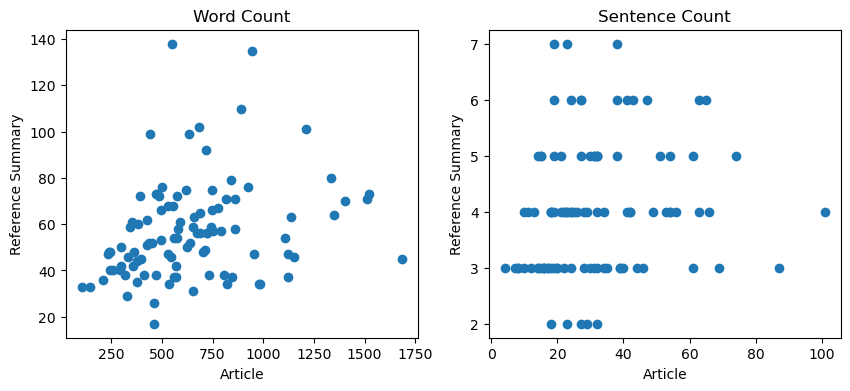

In [11]:
samples = df_val.sample(n=100, random_state=0)
samples.reset_index(inplace=True)

article_wc = [len(article.split()) for article in samples['article']]
summary_wc = [len(summary.split()) for summary in samples['highlights']]
stop_words = stopwords.words('english')

tfidf = TfidfVectorizer(stop_words=stop_words, norm='l1')
article_sc = [len(nltk.tokenize.sent_tokenize(a)) for a in samples['article']]
summary_sc = [len(nltk.tokenize.sent_tokenize(s)) for s in samples['highlights']]

fig = plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(article_wc, summary_wc)
plt.xlabel('Article')
plt.ylabel('Reference Summary')
plt.title('Word Count')
plt.subplot(1, 2, 2)
plt.scatter(article_sc, summary_sc)
plt.xlabel('Article')
plt.ylabel('Reference Summary')
plt.title('Sentence Count')
plt.show()

## Step 4: Implement baseline summarizer

This article ([link](https://www.learndatasci.com/glossary/tf-idf-term-frequency-inverse-document-frequency/#:~:text=Using%20scikit%2Dlearn-,What%20is%20TF%2DIDF%3F,%2C%20relative%20to%20a%20corpus)) provided a quick intro to TF-IDF.

**NOTE**: Need to figure out whether the parameter `summary_len` in function `summarize()` should be a hyperparameter or a fixed number (3 - 4 suggested by the sentence counts plot in EDA section above).

In [12]:
def summarize(text: str, summary_len: int) -> str:
    """ Extract sentences from text as the summary using TF-IDF scoring.

    Parameters:
        - text (str): a string of text needs to be summarized.
        - summary_len (int): number of sentences in the summary.

    Returns:
        summary (str): a string of summary

    Notes:
        The score for each sentence is the average TF-IDF score of words (tokens)
        whose score is not zero.
    """
    # Initialize a TF-IDF Vectorizer.
    stop_words = stopwords.words('english')
    tfidf = TfidfVectorizer(stop_words=stop_words, norm='l1')
    # Tokenize sentences (ie, split text into individual sentences).
    sents = nltk.tokenize.sent_tokenize(text)
    # Remove overly short sentences.
    sent_lens = [len(sent) for sent in sents]
    avg_sent_len = sum(sent_lens) / len(sent_lens)
    sents = [sent for sent in sents if len(sent) > avg_sent_len * 0.5]
    # Perform TF-IDF.
    X = tfidf.fit_transform(sents)
    # Compute each sentence score.
    scores = np.zeros(len(sents))
    for i in range(len(sents)):
        score = X[i,:][X[i,:] != 0].mean()
        scores[i] = score

    # Sort the scores.
    sort_idx = np.argsort(-scores)
    # Concatenate sentences with top scores as the summary.
    summary = ''
    for i in sort_idx[:summary_len]:
        summary += (sents[i] + ' ')
    return summary

In [13]:
# Print the generated summary for an example article.
summarize(df_train['article'][0], 4)

'Fargo Catholic Diocese in North Dakota (pictured) is where the bishop is located . The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. Symptoms of hepatitis A include fever, tiredness, loss of appetite, nausea and abdominal discomfort. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. '

## Step 5: Evaluate generated summaries

### ROUGE scores
This article ([link](https://medium.com/nlplanet/two-minutes-nlp-learn-the-rouge-metric-by-examples-f179cc285499)) provides enough background knowledge we need to know to use ROUGE. We leverage the existing package `Rouge` to compute ROUGE scores in the following code cells. Note that `rouge_scores` in the below code cell is a list of list, where each inner list wraps a dictionary holding all rouge scores for one article. The dictionary has three key-value pairs. Each pair includes detailed data for rouge-1, rouge-2, and rouge-L. Each corresponding values is also a dictionary made of another three key-value pairs recording recall ('r'), precission ('p'), and F1-score ('f'). Here is an example:

```python
[[{'rouge-1': {'r': 0.1724137931034483,
    'p': 0.09803921568627451,
    'f': 0.12499999537812517},
   'rouge-2': {'r': 0.06451612903225806,
    'p': 0.028985507246376812,
    'f': 0.039999995722000456},
   'rouge-l': {'r': 0.1724137931034483,
    'p': 0.09803921568627451,
    'f': 0.12499999537812517}}],
   ... (rouge scores for other sentences) ]
```
We choose to use F1 score as it combines recall and precision. We extract F1 score of rouge-1, rouge-2, and rouge-L respectively and plot them in a histogram.

In [14]:
rouge = Rouge()
rouge_scores = []
for i in range(len(samples)):
    hyps_summary = summarize(samples['article'][i], 4)
    refs_summary = samples['highlights'][i]
    score = rouge.get_scores(hyps=hyps_summary, refs=refs_summary)
    rouge_scores.append(score)

rouge1_f1 = [record[0]['rouge-1']['f'] for record in rouge_scores]
rouge2_f1 = [record[0]['rouge-2']['f'] for record in rouge_scores]
rougeL_f1 = [record[0]['rouge-l']['f'] for record in rouge_scores]

Visualize the distribution of these ROUGE scores from the `samples`. I learn to plot histogram with percentage as the y-axis from this Stackoverflow post ([link](https://stackoverflow.com/a/51477080)).

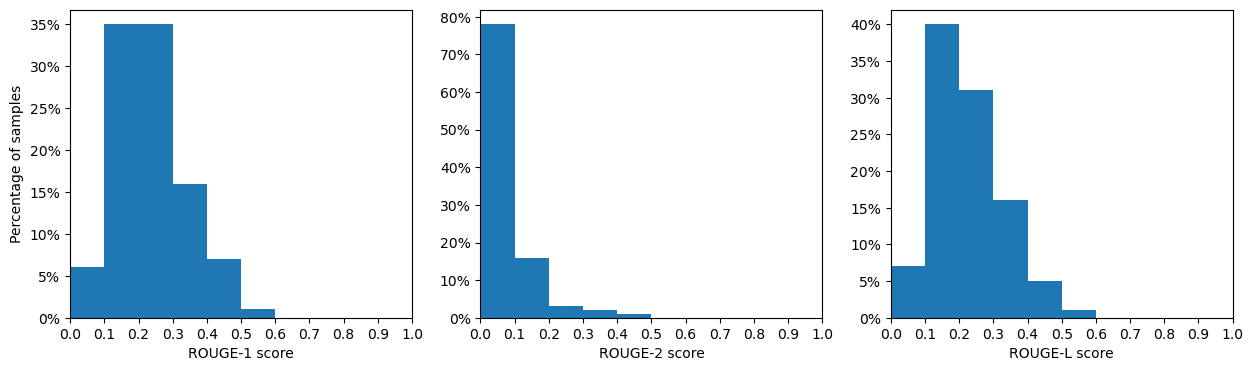

In [15]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.hist(rouge1_f1, bins=[0.1*i for i in range(11)],
         weights=np.ones(len(rouge1_f1))/len(rouge1_f1))
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.xlim(0, 1)
plt.xticks([0.1*i for i in range(11)])
plt.xlabel('ROUGE-1 score')
plt.ylabel('Percentage of samples')

plt.subplot(1, 3, 2)
plt.hist(rouge2_f1, bins=[0.1*i for i in range(11)],
         weights=np.ones(len(rouge2_f1))/len(rouge2_f1))
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.xlim(0, 1)
plt.xticks([0.1*i for i in range(11)])
plt.xlabel('ROUGE-2 score')

plt.subplot(1, 3, 3)
plt.hist(rougeL_f1, bins=[0.1*i for i in range(11)],
         weights=np.ones(len(rougeL_f1))/len(rougeL_f1))
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.xlim(0, 1)
plt.xticks([0.1*i for i in range(11)])
plt.xlabel('ROUGE-L score')

plt.show()

### BLEU scores

In [16]:
bleu_scores = []
for i in range(len(samples)):
    hyps_summary = summarize(samples['article'][i], 4)
    refs_summary = samples['highlights'][i]
    score = sentence_bleu(references=[refs_summary.split()],
                               hypothesis=hyps_summary.split())
    bleu_scores.append(score)

/Users/zionshane/miniconda3/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/zionshane/miniconda3/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/zionshane/miniconda3/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram

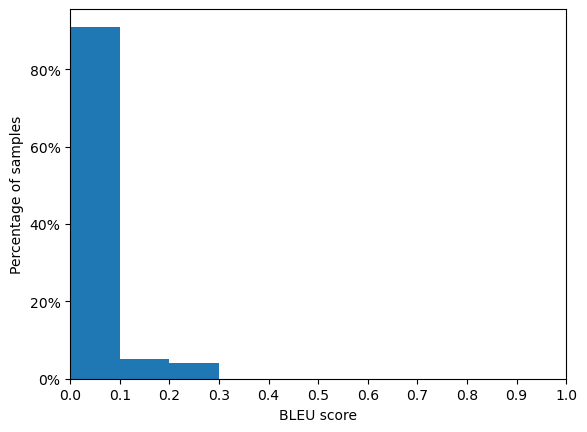

In [17]:
plt.hist(bleu_scores, bins=[0.1*i for i in range(11)],
         weights=np.ones(len(bleu_scores))/len(bleu_scores))
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.xlim(0, 1)
plt.xticks([0.1*i for i in range(11)])
plt.xlabel('BLEU score')
plt.ylabel('Percentage of samples')
plt.show()

### BERT scores

Tips ([link](https://stackoverflow.com/a/68476851)) to remove the annoying warnings returned from `bert_score.score()`.
```
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
```

In [18]:
# NOTE: this cell takes 1m 40s to run on a MacBook Air 2021 with A1 chip.

from transformers import logging
logging.set_verbosity_error()

bert_scores = []
for i in range(len(samples)):
    hyps_summary = summarize(samples['article'][i], 4)
    refs_summary = samples['highlights'][i]
    P, R, F1 = bert_score.score(cands=[hyps_summary], refs=[refs_summary],
                                lang='en', rescale_with_baseline=True)
    bert_scores.append(F1.item())

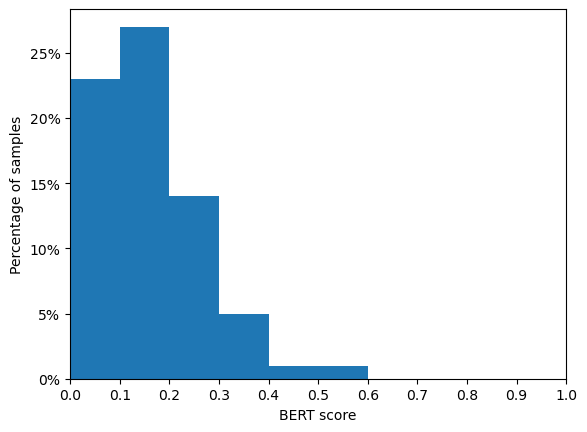

In [19]:
plt.hist(bert_scores, bins=[0.1*i for i in range(11)],
         weights=np.ones(len(bert_scores))/len(bert_scores))
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.xlim(0, 1)
plt.xticks([0.1*i for i in range(11)])
plt.xlabel('BERT score')
plt.ylabel('Percentage of samples')
plt.show()

### METEOR scores

In [20]:
meteor_scores = []
for i in range(len(samples)):
    hyps_summary = summarize(samples['article'][i], 4)
    refs_summary = samples['highlights'][i]
    score = meteor_score(references=[refs_summary.split()],
                               hypothesis=hyps_summary.split())
    meteor_scores.append(score)

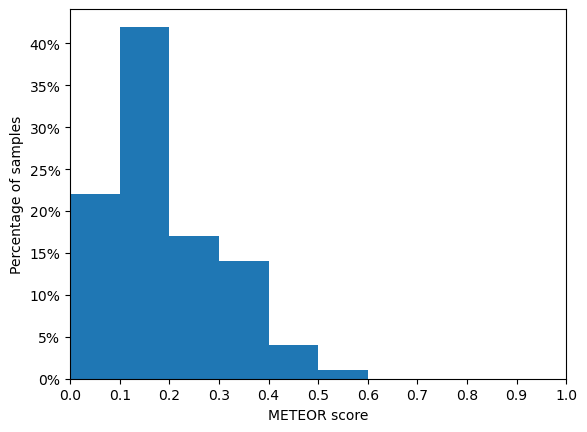

In [21]:
plt.hist(meteor_scores, bins=[0.1*i for i in range(11)],
         weights=np.ones(len(meteor_scores))/len(meteor_scores))
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.xlim(0, 1)
plt.xticks([0.1*i for i in range(11)])
plt.xlabel('METEOR score')
plt.ylabel('Percentage of samples')
plt.show()